<a href="https://colab.research.google.com/github/GiuliaLanzillotta/exercises/blob/master/Color_compression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Color compression
Today I will compress an high-quality image with a clustering algorithm. <br>
For the purpose of the exercise I will use an old picture of me. 


## Loading the data

In [0]:
from matplotlib import image
from matplotlib import pyplot

uint8
(1366, 2048, 3)


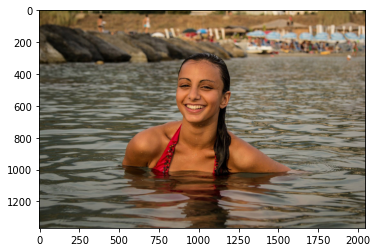

In [2]:
data = image.imread('drive/My Drive/picture.jpg')
print(data.dtype)
print(data.shape)
pyplot.imshow(data)
pyplot.show()


With the data we have collected in the previous cell we can answer the following question: 

> #### What is the dimension of the image?



In [3]:
# The data type is suggesting that every pixel is encoded as a sequence of 8 bits
pixel = 8
channels = 3
width = 2048
height = 1366 
dimension = pixel*channels*width*height 
print("The dimension then is ", dimension, " bits")

The dimension then is  67141632  bits


Now to run any clustering algorithm on the image we need to transform it into a *set of points*. <br>
For this purpose we will treat each pixel in the image as a 3-dimensional vector (R,G,B).


In [0]:
# To make each pixel a 3D vector we have to extract all the vectors in the image,
# which means we have to reshape it : [height, width, channels] -> [height*width, channels]
pixels = data.reshape(height*width,channels)

In [6]:
pixels[0]

array([89, 74, 31], dtype=uint8)

## Implementing K-means 

In [0]:
k = 16 # number of clusters 

#### The algorithm : 
      Randomly initialize the centroids
      repeat until convergence: 
        1. assign each point to the nearest centroid's cluster
        2. recompute the centroids
        

In [0]:
import numpy as np

In [0]:
# Helper function to compute the assignments 
def compute_assignment(X,U):
  """
  Computes the assignment of each point in X to a cluster by 
  minimising the Euclidean distance between the point and the cluster's
  centroid. 
  """
  distances = np.sum((X[:, np.newaxis] - U[np.newaxis, :])**2, axis=2) 
  z = np.argmin(distances, axis=1)
  return z

In [0]:
# Helper function to recompute the centroids
def recompute_centroids(points,z,k):
  """
  Recomputes the centroid as the center of mass (the mean) of the points 
  assigned to each cluster, and 
  -----------
  Parameters: 
  - points: np.array
  - z: list of int.
      The list of assignments.
  -----------
  Returns:  np.array and  int.
      Returns the matrix of centroids U and the new number of clusters.
  """
  centroids = []
  for i in range(k):
    points_k = points[z==i]
    if len(points_k) > 0: 
      centroids.append(np.mean(points_k, axis=0))
  return np.array(centroids), len(centroids)

In [0]:
def do_loop(X,U,z,k):
  """
  Performs k-means main loop.
  """
  convergence = False
  dropped = 0

  while(not convergence and k>0):
    # STEP 1
    U, l = recompute_centroids(X, z, k) 
    dropped += k-l
    k = l
    # STEP 2
    z_new = compute_assignment(X,U)
    convergence = (z == z_new).all()
    z = z_new 
  
  return U,z,k

In [0]:
import time

In [0]:
# Random initialization : as we'll see later, this step is crucial in terms of the 
# optimality of the solution found 
X = pixels.copy()
U = X[np.random.choice(X.shape[0], size=k, replace=False)]
z = compute_assignment(X,U)

start_time = time.time()
U,z,k = do_loop(X,U,z,k)
end_time = time.time()

In [84]:
print("Converged in ",end_time-start_time," seconds")

Converged in  152.00536918640137  seconds


## Visualising results 
To visualise the results on the original image we have to perform the following steps: 

    1. Substitute each point with the corresponding centroid 
    2. Display the compressed image 

In [0]:
#. Substituing each point with the corresponding centroid 
for i in range(k):
  X[z==i] = U[i,:]

In [0]:
import matplotlib.pyplot as plt

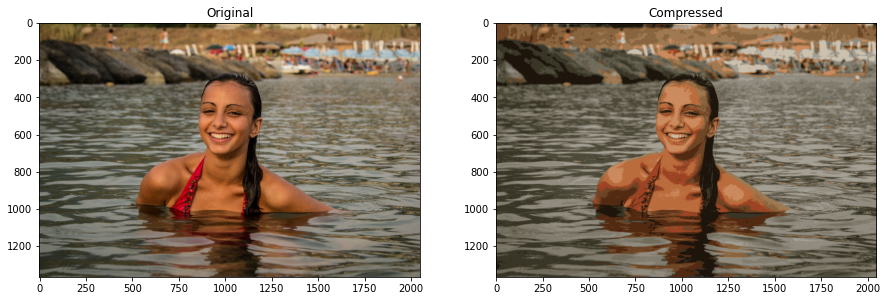

In [100]:
#. Displaying the compressed image against the original one
fig, ax = plt.subplots(1,2,figsize=(15,15))
ax[0].imshow(data) # this is the original image 
ax[0].set_title("Original")
compressed_image = X.reshape(height,width,3)
ax[1].imshow(compressed_image) # this is the compressed one
ax[1].set_title("Compressed")
pyplot.show()


We can also visualize the result from a purely geometrical point of view with a scatter plot. 

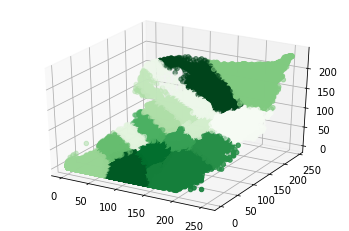

In [83]:
#. Plotting in 3d 
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter3D(X[:,0], X[:,1], X[:,2], c=z, cmap='Greens')

## Improving K-means : **K-means ++**
To improve the optimality of the function we can use the hack suggested by the k-means ++ solution, which interestingly only focuses on the *random initialization* step. 
<br> 
The **idea** is the following: instead of sampling the centroids from a uniform distribution over the data we could sample it from a categorical distribution, biased towards the *regions of the input space* that are not yet *covered* by the initialization. 

In [0]:
# The first centroid is sampled randomly from a uniform over the data 
X = pixels.copy()
U = X[np.random.choice(X.shape[0], size=1, replace=False)]
# The next centroids are sampled from a categorical where the points 
# with larger distance from the nearest centroid are given an higher weight 
for i in range(k-1):
  distances = np.min(np.sum((X[:, np.newaxis] - U[np.newaxis, :])**2, axis=2),axis=1)
  p = distances/np.sum(distances)
  u = X[np.random.choice(X.shape[0], size=1, replace=False, p=p)]
  U = np.row_stack((U,u))

In [21]:
U.shape

(16, 3)

Let's now see if we can notice an improvement wrt the previous naive solution by using this initialization.
<br>
Note, the following is the same code as above.

In [0]:
z = compute_assignment(X,U)

start_time = time.time()
U,z,k = do_loop(X,U,z,k)
end_time = time.time()

In [24]:
print("Converged in ",end_time-start_time," seconds")

Converged in  167.7680025100708  seconds


We actually needded more time to converge in this case. <br>
Is the solution different though? 

In [0]:
#. Substituing each point with the corresponding centroid 
for i in range(k):
  X[z==i] = U[i,:]

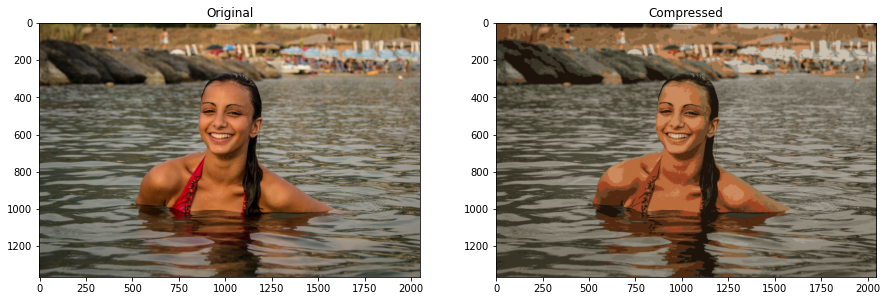

In [28]:
#. Displaying the compressed image against the original one
fig, ax = plt.subplots(1,2,figsize=(15,15))
ax[0].imshow(data) # this is the original image 
ax[0].set_title("Original")
compressed_image = X.reshape(height,width,3)
ax[1].imshow(compressed_image) # this is the compressed one
ax[1].set_title("Compressed")
pyplot.show()

> #### Conclusions 
Just by looking at the two compressed images we can conclude that in this case either the previous random initialization was already pretty good or the geometry of the input space is not such that the optimum to which K-means converges is far from the global optimum.

## Tuning **K**
The question comes natural: **what happens if we choose different values for k**? <br>
In the following cells we are going to apply the prevoius code to different k-values and we are going to compare the results. 

*Nota bene*: we are not going to use the K-means ++ implementation to speed it up a bit. 

In [0]:
Ks = [2,4,8,16] # the different values of k

In [0]:
Us = []
Zs = []
X = pixels.copy()
for k in Ks[]: 
    print("Starting compression to ", k, " clusters.")
    U = X[np.random.choice(X.shape[0], size=k, replace=False)]
    z = compute_assignment(X,U)

    start_time = time.time()
    U,z,k = do_loop(X,U,z,k)
    Us.append(U)
    Zs.append(z)
    end_time = time.time()
    print("Number of final clusters : ",k)
    print("Time of execution: ", end_time-start_time)

Now we'll have a look at the results.

In [0]:
#. Substituing each point with the corresponding centroid 
Xs = []
for k in range(len(Ks[])):
  X = pixels.copy()
  U = Us[k]
  z = Zs[k]
  for i in range(U.shape[0]):
    X[z==i] = U[i,:]
  Xs.append(X)

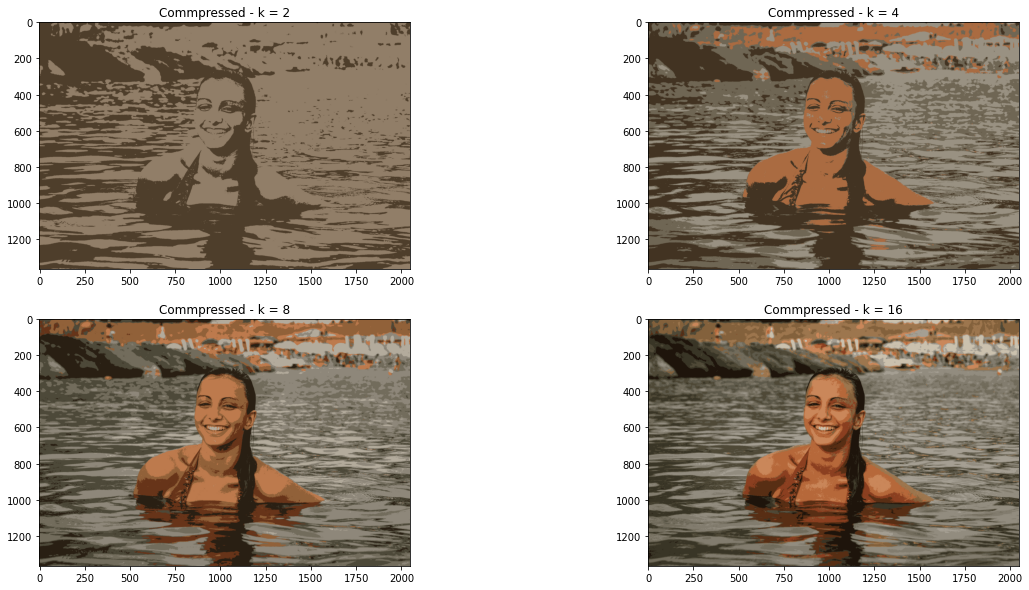

In [49]:
#. Displaying the compressed image against the original one
fig, ax = plt.subplots(2,2,figsize=(20,10))

for k in range(len(Ks[:4])):
  row = int(k/2)
  col = k%2
  ax[row,col].imshow(Xs[k].reshape(height,width,3))
  title = "Commpressed - k = "+str(Ks[k])
  ax[row,col].set_title(title)

pyplot.show()

## Improving K-means: Gaussian mixtures
K-means is a simple yet effective algorithm but it has a limited modeling power. We will now use a different approach to the same problem (clustering the pixels in an image) which will improve the K-means solution on two aspects: 

  1. We will be able to model not only the location, but also the shape of each cluster

  2. It will be possible to assign each point to multiple clusters (*soft-assignment*), hence it will be possible to discover a number of clusters k smaller the the initial value of the parameter. 

The different approach we will now look at is a *generative approach*: we will make an hypothesis on the process that generated the data and we will use this hypothesis to learn a density from the data. 

> #### Our hypothesis: 
We suppose that the data comes from a **Mixture distribution**. <br>
Moreover, we suppose that the base densities of this mixture are *Gaussians*. Why? Because it makes things easier. 

Last step before getting into the code: <br>
we cannot directly solve MLE for such a mixture, hence we'll make use of a quite famous *alternation* optimization scheme, namely the **expectation-maximization** algorithm. 



Let's use **Sklearn** implementation for this one. 

In [12]:
from sklearn.mixture import GaussianMixture 
X = pixels.copy()
gmm = GaussianMixture(n_components = 16) 
start_time = time.time()
gmm.fit(X)
end_time = time.time()
z = gmm.predict(X) 
print("Terminated in ",end_time-start_time," seconds.")

Terminated in  229.83140969276428  seconds.


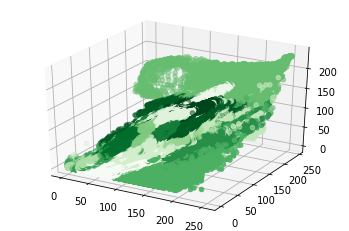

In [13]:
#. Plotting in 3d 
ax = plt.axes(projection='3d')
ax.scatter3D(X[:,0], X[:,1], X[:,2], c=z, cmap='Greens');

In [0]:
#. Substituing each point with the corresponding centroid 
for i in range(k):
  X[z==i] = gmm.means_[i,:]

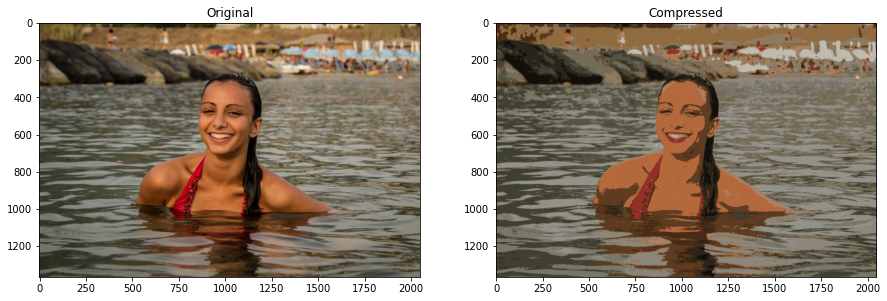

In [18]:
#. Displaying the compressed image against the original one
fig, ax = plt.subplots(1,2,figsize=(15,15))
ax[0].imshow(data) # this is the original image 
ax[0].set_title("Original")
compressed_image = X.reshape(height,width,3)
ax[1].imshow(compressed_image) # this is the compressed one
ax[1].set_title("Compressed")
pyplot.show()